<a href="https://colab.research.google.com/github/wandadesi/Sea-Level-Forecast-ARIMA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Library
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [ ]:
# @title Import data
data = pd.read_csv('/content/sea_levels_2015.csv')

# EDA & Preprocessing

In [ ]:
# @title Missing value

data.isnull().sum()


,0
Time,0
GMSL,0
GMSL uncertainty,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Time              1608 non-null   object 
 1   GMSL              1608 non-null   float64
 2   GMSL uncertainty  1608 non-null   float64
dtypes: float64(2), object(1)
memory usage: 37.8+ KB


In [ ]:
data['Time'] = pd.to_datetime(data['Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              1608 non-null   datetime64[ns]
 1   GMSL              1608 non-null   float64       
 2   GMSL uncertainty  1608 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 37.8 KB


In [ ]:
data.head()

,Time,GMSL,GMSL uncertainty
0,1880-01-15,-183.0,24.2
1,1880-02-15,-171.1,24.2
2,1880-03-15,-164.3,24.2
3,1880-04-15,-158.2,24.2
4,1880-05-15,-158.7,24.2


In [ ]:
# @title Plot GMSL Overtime
fig = px.line(data, x="Time", y="GMSL", title='GMSL over Time')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

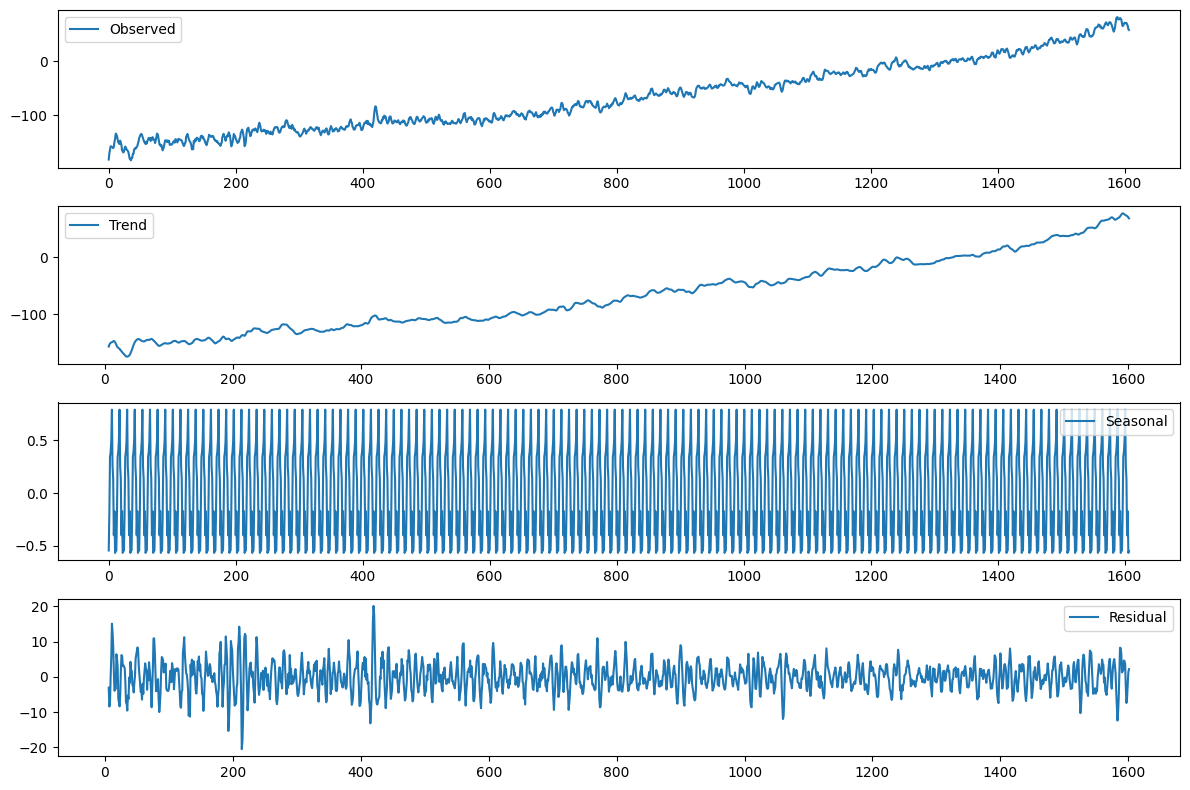

In [ ]:
# @title Plot Decompose
decomposition = seasonal_decompose(data['GMSL'], model='additive', period=12)  # Assuming yearly seasonality

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:
# @title Boxplot per year
data['Year'] = pd.to_datetime(data['Time']).dt.year  # Extract year from 'Time' column after converting to datetime

fig = px.box(data, x='Year', y='GMSL', title='Boxplot of GMSL per Year')
fig.show()

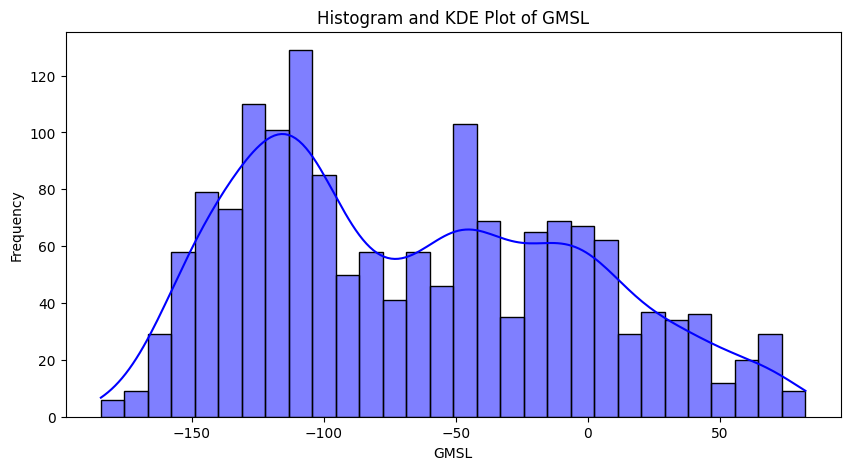

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data["GMSL"], kde=True, bins=30, color="blue")
plt.xlabel("GMSL")
plt.ylabel("Frequency")
plt.title("Histogram and KDE Plot of GMSL")
plt.show()


### Plot Moving Average

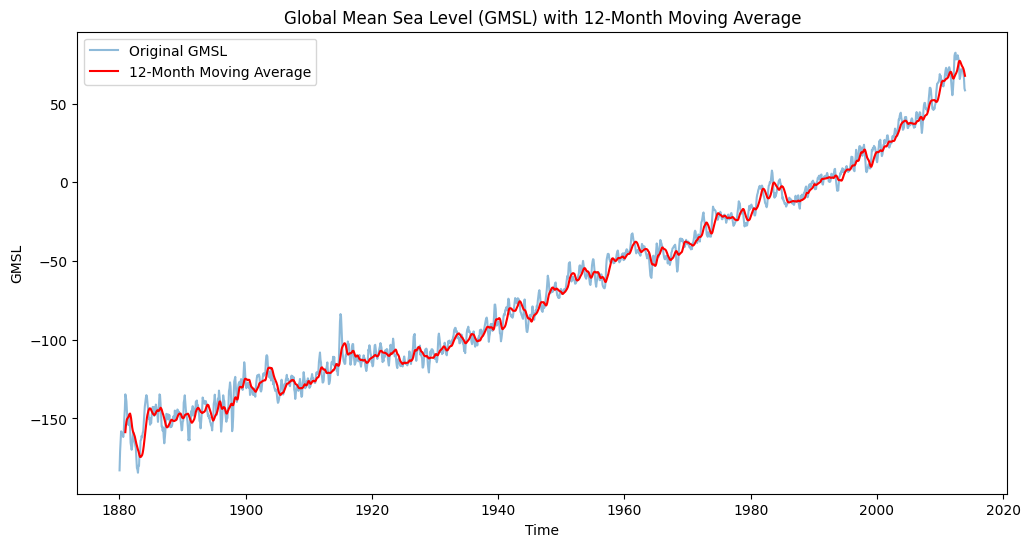

In [ ]:
import matplotlib.pyplot as plt

# Menentukan window size (misalnya 12 bulan jika data bulanan)
window_size = 12
data['GMSL_MA'] = data['GMSL'].rolling(window=window_size).mean()

# Plot GMSL asli dan Moving Average
plt.figure(figsize=(12, 6))
plt.plot(data["Time"], data["GMSL"], label="Original GMSL", alpha=0.5)
plt.plot(data["Time"], data["GMSL_MA"], label=f"{window_size}-Month Moving Average", color="red")
plt.xlabel("Time")
plt.ylabel("GMSL")
plt.title(f"Global Mean Sea Level (GMSL) with {window_size}-Month Moving Average")
plt.legend()
plt.show()


# Split Data

In [ ]:
data['Time'] = pd.to_datetime(data['Time'])

# Now you can use the .dt accessor for filtering
train_data = data[data['Time'].dt.year.between(1880, 1986)]  # Filter data based on year in 'Time' column
test_data = data[data['Time'].dt.year >= 1987]  # Filter data based on year in 'Time' column

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1284, 3)
Test data shape: (324, 3)


# Make Data Stationary (Define (d))

In [ ]:
# @title ADF Test
result = adfuller(train_data['GMSL'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")


ADF Statistic: -0.1935130690320439
p-value: 0.9392904380166606
Critical Values: {'1%': np.float64(-3.4355217427788793), '5%': np.float64(-2.8638238726872296), '10%': np.float64(-2.5679859566283705)}
The time series is non-stationary.


ADF Statistic (Differenced): -12.606249221866022
p-value (Differenced): 1.6933686598933492e-23
Critical Values (Differenced): {'1%': np.float64(-3.4355217427788793), '5%': np.float64(-2.8638238726872296), '10%': np.float64(-2.5679859566283705)}
The differenced time series is stationary.


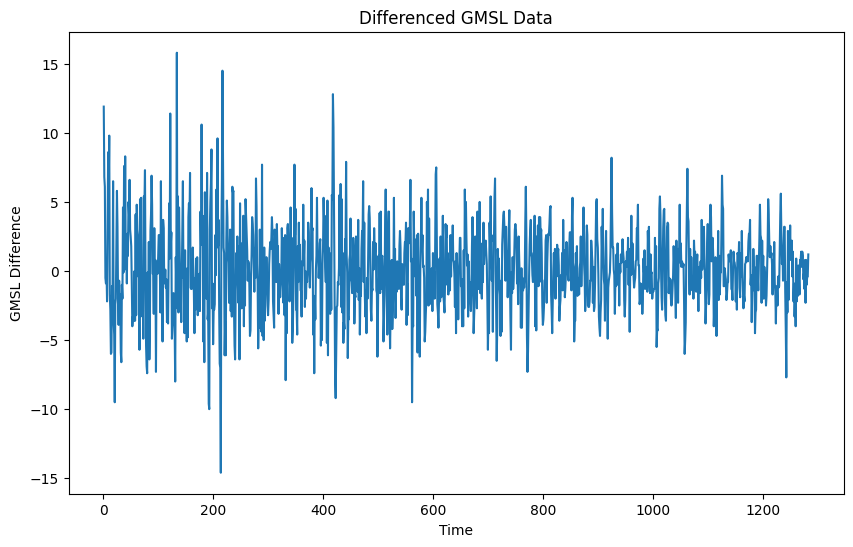

In [ ]:
# @title Differencing
# Differencing the data
differenced_data = train_data['GMSL'].diff().dropna()

# ADF Test on differenced data
result_diff = adfuller(differenced_data)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values (Differenced):', result_diff[4])

if result_diff[1] <= 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is non-stationary.")


# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(differenced_data)
plt.title('Differenced GMSL Data')
plt.xlabel('Time')
plt.ylabel('GMSL Difference')
plt.show()


# Define (p,q)

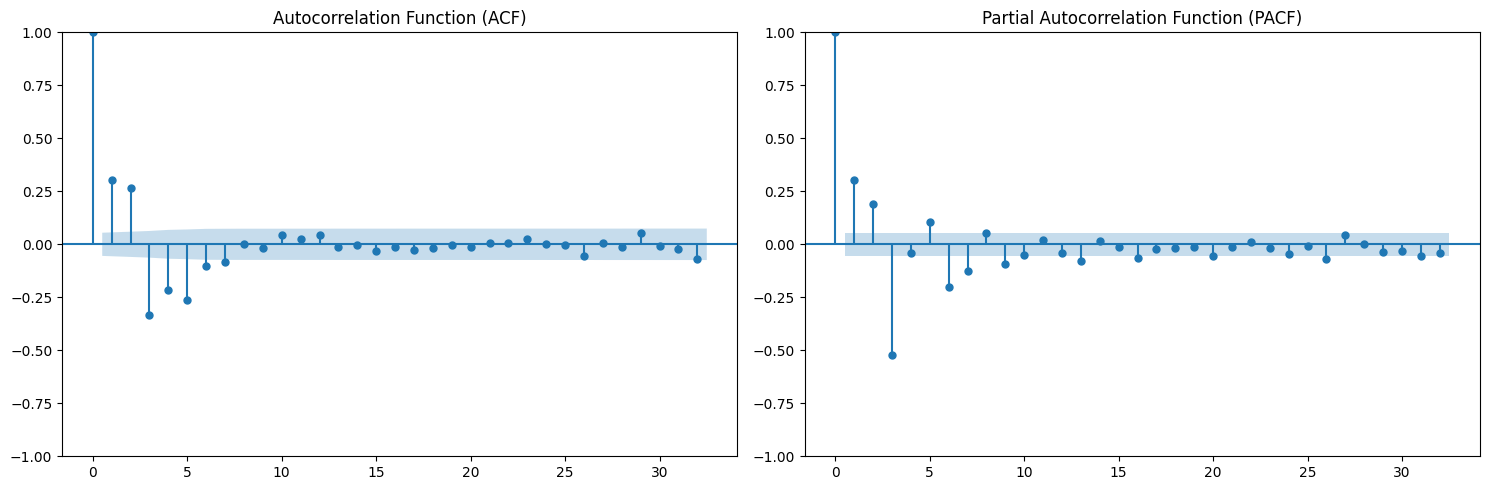

In [ ]:
# @title ACF PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate and plot ACF and PACF for the differenced data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(differenced_data, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(differenced_data, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate ACF and PACF
acf_vals = acf(differenced_data)
pacf_vals = pacf(differenced_data)

# Print the values
print("ACF Values:")
print(acf_vals)
print("\nPACF Values:")
pacf_vals


ACF Values:
[ 1.00000000e+00  3.03541048e-01  2.63688503e-01 -3.35456950e-01
 -2.16932318e-01 -2.61615082e-01 -1.00756261e-01 -8.23170547e-02
  7.75992012e-04 -1.72216790e-02  4.45309140e-02  2.29536295e-02
  4.55766481e-02 -1.27426606e-02 -1.01156436e-03 -3.09800485e-02
 -1.14294851e-02 -2.85884700e-02 -1.72752048e-02 -4.17117410e-03
 -1.21972716e-02  6.06141009e-03  3.81867561e-03  2.49391045e-02
  9.06754426e-04 -1.92927504e-03 -5.72272589e-02  7.45932509e-03
 -1.40639588e-02  5.38409214e-02 -7.36190102e-03 -1.99450380e-02]

PACF Values:


array([ 1.        ,  0.30377782,  0.1892868 , -0.52420951, -0.04140692,
        0.10504218, -0.20170331, -0.1262435 ,  0.05262823, -0.09332568,
       -0.04895216,  0.02024291, -0.04377741, -0.07821829,  0.01599598,
       -0.01452002, -0.06516319, -0.0238278 , -0.0155097 , -0.01183606,
       -0.05713913, -0.01318834,  0.01090164, -0.01793704, -0.0492126 ,
       -0.00992323, -0.07306637,  0.04442104,  0.00119868, -0.03975656,
       -0.03022819, -0.05726108])

In [ ]:
# ACF
significant_acf_lags = [i for i, val in enumerate(acf_vals) if abs(val) > 1.96 / np.sqrt(len(differenced_data))]
insignificant_acf_lags = [i for i, val in enumerate(acf_vals) if abs(val) <= 1.96 / np.sqrt(len(differenced_data))]

# PACF
significant_pacf_lags = [i for i, val in enumerate(pacf_vals) if abs(val) > 1.96 / np.sqrt(len(differenced_data))]
insignificant_pacf_lags = [i for i, val in enumerate(pacf_vals) if abs(val) <= 1.96 / np.sqrt(len(differenced_data))]

print("Significant ACF Lags:", significant_acf_lags)
print("Insignificant ACF Lags:", insignificant_acf_lags)
print("Significant PACF Lags:", significant_pacf_lags)
print("Insignificant PACF Lags:", insignificant_pacf_lags)


Significant ACF Lags: [0, 1, 2, 3, 4, 5, 6, 7, 26]
Insignificant ACF Lags: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31]
Significant PACF Lags: [0, 1, 2, 3, 5, 6, 7, 9, 13, 16, 20, 26, 31]
Insignificant PACF Lags: [4, 8, 10, 11, 12, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30]


# ARIMA (p.d.q)

In [ ]:
# @title ARIMA(1,0,0) -> AR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit the ARIMA model
model3 = ARIMA(train_data['GMSL'], order=(1, 0, 0))
model3_fit = model3.fit()
print(model3_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   GMSL   No. Observations:                 1284
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3300.372
Date:                Tue, 25 Mar 2025   AIC                           6606.745
Time:                        13:03:17   BIC                           6622.218
Sample:                             0   HQIC                          6612.554
                               - 1284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -89.6535     55.264     -1.622      0.105    -197.970      18.663
ar.L1          0.9988      0.002    475.997      0.000       0.995       1.003
sigma2         9.9561      0.302     32.933      0.0

Root Mean Squared Error (RMSE): 2.5371393823632666


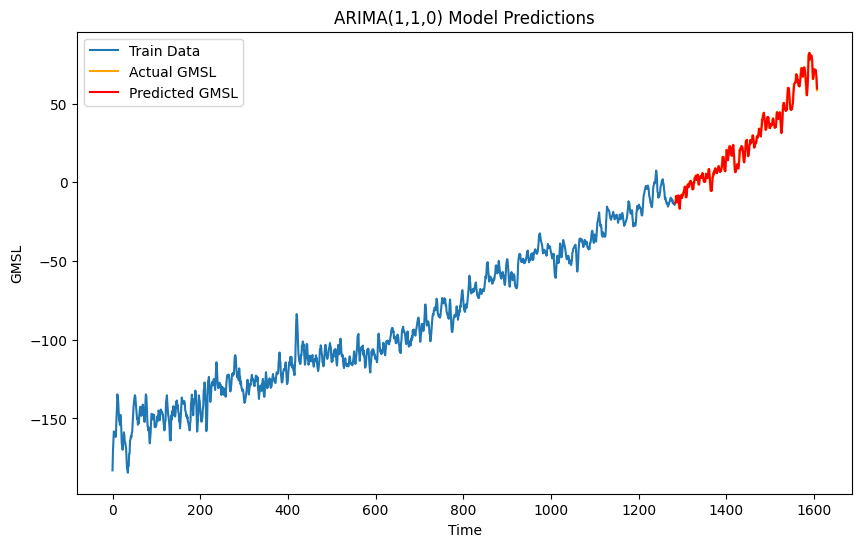

In [ ]:
# @title predict with model ARIMA (1,0,0) -> AR

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model3 = sm.tsa.ARIMA(history, order=(1,0,0))
    model3_fit = model3.fit()
    yhat = model3_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['GMSL'], label='Train Data')
plt.plot(test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')
plt.title('ARIMA(1,1,0) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()

In [ ]:
# @title ARIMA(0,0,1) -> MA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit the ARIMA model
model4 = ARIMA(train_data['GMSL'], order=(0, 0, 1))
model4_fit = model4.fit()
print(model4_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                   GMSL   No. Observations:                 1284
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5909.114
Date:                Tue, 25 Mar 2025   AIC                          11824.228
Time:                        13:04:52   BIC                          11839.701
Sample:                             0   HQIC                         11830.037
                               - 1284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -89.5409      1.361    -65.796      0.000     -92.208     -86.874
ma.L1          0.9381      0.011     82.009      0.000       0.916       0.961
sigma2       580.9667     31.980     18.166      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Root Mean Squared Error (RMSE): 55.08375306828106


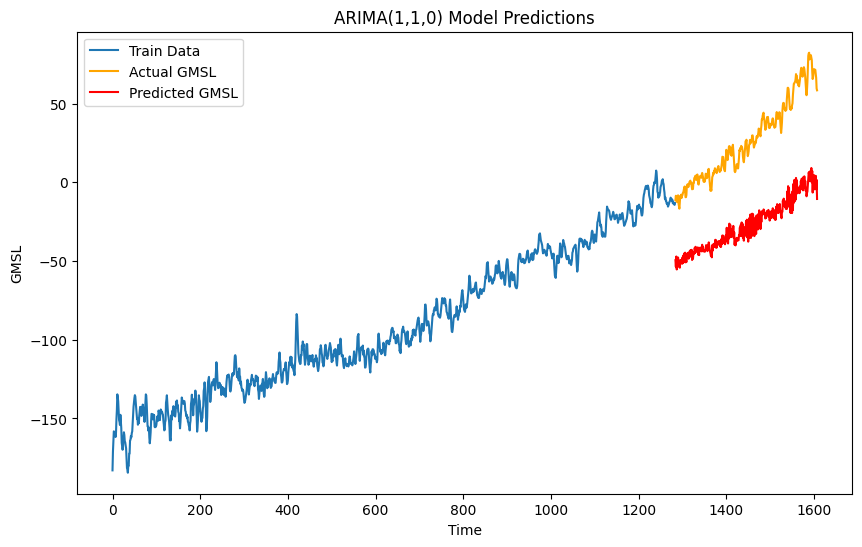

In [ ]:
# @title predict with model ARIMA (0,0,1)-> MA

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model4 = sm.tsa.ARIMA(history, order=(0,0,1))
    model4_fit = model4.fit()
    yhat = model4_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['GMSL'], label='Train Data')
plt.plot(test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')
plt.title('ARIMA(1,1,0) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()

In [ ]:
# @title ARIMA(1,1,0) -> ARI
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit the ARIMA model
model0 = ARIMA(train_data['GMSL'], order=(1, 1, 0))
model0_fit = model0.fit()
print(model0_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   GMSL   No. Observations:                 1284
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3231.819
Date:                Tue, 25 Mar 2025   AIC                           6467.637
Time:                        04:59:55   BIC                           6477.951
Sample:                             0   HQIC                          6471.510
                               - 1284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3078      0.021     14.324      0.000       0.266       0.350
sigma2         9.0245      0.277     32.531      0.000       8.481       9.568
Ljung-Box (L1) (Q):                   5.04   Jarque-

Root Mean Squared Error (RMSE): 2.3010692978815586


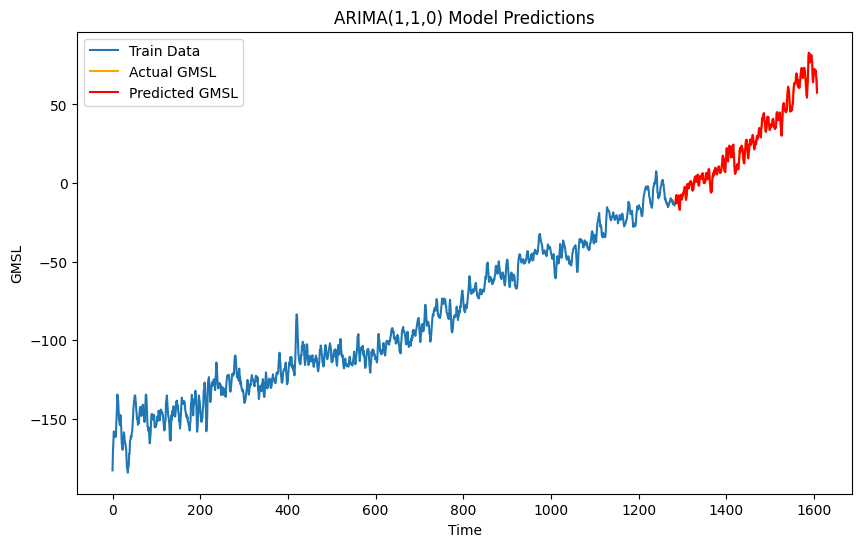

In [ ]:
# @title predict with model ARIMA (1,1,0) -> ARI

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model0 = sm.tsa.ARIMA(history, order=(1,1,0))
    model0_fit = model0.fit()
    yhat = model0_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['GMSL'], label='Train Data')
plt.plot(test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')
plt.title('ARIMA(1,1,0) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()


In [ ]:
# @title ARIMA(0,1,1) -> IMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit the ARIMA model
model2 = ARIMA(train_data['GMSL'], order=(0, 1, 1))
model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   GMSL   No. Observations:                 1284
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3256.075
Date:                Tue, 25 Mar 2025   AIC                           6516.150
Time:                        05:05:08   BIC                           6526.464
Sample:                             0   HQIC                          6520.023
                               - 1284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1871      0.023      8.160      0.000       0.142       0.232
sigma2         9.3728      0.284     32.955      0.000       8.815       9.930
Ljung-Box (L1) (Q):                   6.58   Jarque-

Root Mean Squared Error (RMSE): 2.380356667763454


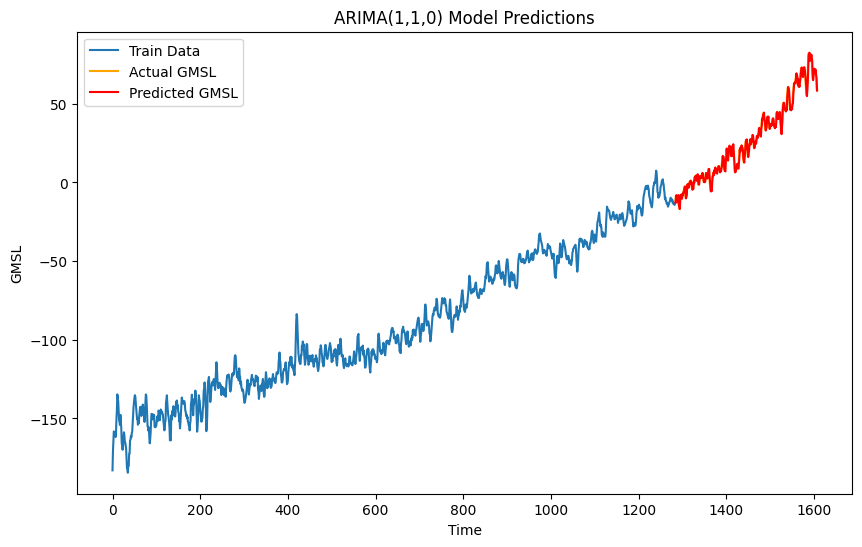

In [ ]:
# @title predict with model ARIMA (0,1,1) -> IMA

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model2 = sm.tsa.ARIMA(history, order=(0,1,1))
    model2_fit = model2.fit()
    yhat = model2_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['GMSL'], label='Train Data')
plt.plot(test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')
plt.title('ARIMA(1,1,0) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()

In [ ]:
# @title ARIMA (1,1,1)

# Fit the ARIMA model (p=1, d=1, q=1)
model1 = ARIMA(train_data['GMSL'], order=(1, 1, 1))
model1_fit = model1.fit()
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   GMSL   No. Observations:                 1284
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3226.373
Date:                Tue, 25 Mar 2025   AIC                           6458.747
Time:                        05:00:18   BIC                           6474.217
Sample:                             0   HQIC                          6464.555
                               - 1284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4435      0.070      6.352      0.000       0.307       0.580
ma.L1         -0.1402      0.076     -1.854      0.064      -0.288       0.008
sigma2         8.9483      0.277     32.323      0.0

Root Mean Squared Error (RMSE): 2.3040216652829217


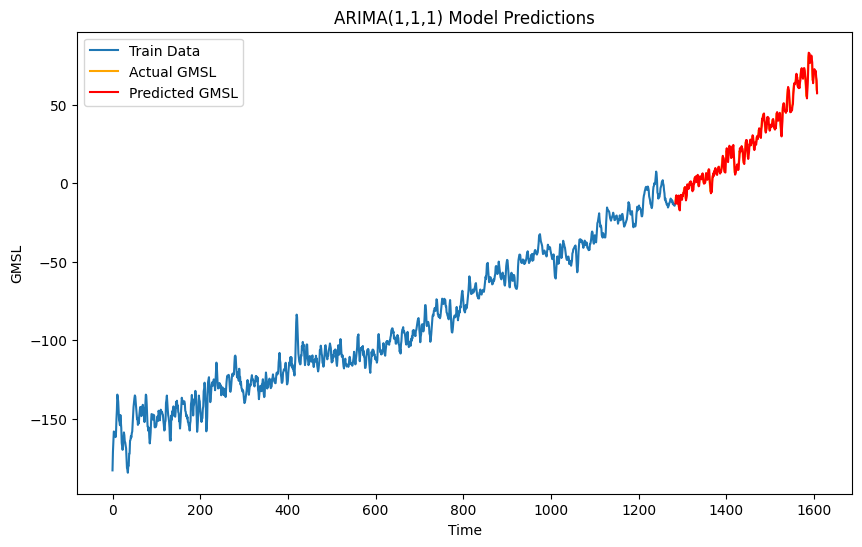

In [ ]:
# @title predict with model ARIMA (1,1,1)

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model1 = sm.tsa.ARIMA(history, order=(1,1,1))
    model1_fit = model1.fit()
    yhat = model1_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['GMSL'], label='Train Data')
plt.plot(test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')
plt.title('ARIMA(1,1,1) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()


In [ ]:
#@title looping best model

# Define a range of p, d, and q values to explore
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_aic = float('inf')
best_bic = float('inf')
best_order = None

for p in p_values:
  for d in d_values:
    for q in q_values:
      try:
        model = ARIMA(train_data['GMSL'], order=(p, d, q))
        model_fit = model.fit()
        current_aic = model_fit.aic
        current_bic = model_fit.bic

        if current_aic < best_aic:
          best_aic = current_aic
          best_bic = current_bic
          best_order = (p, d, q)

        print(f"ARIMA({p}, {d}, {q}): AIC={current_aic}, BIC={current_bic}")

      except Exception as e:
        print(f"Error fitting ARIMA({p}, {d}, {q}): {e}")

print(f"\nBest ARIMA order based on AIC: {best_order}, AIC: {best_aic}, BIC: {best_bic}")

# Now you can use the best_order to fit your final ARIMA model
# For example:
# model = ARIMA(train_data['GMSL'], order=best_order)
# model_fit = model.fit()
# ... (rest of your model training and evaluation)


ARIMA(0, 0, 0): AIC=13443.610824554726, BIC=13453.926295523226


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(0, 0, 1): AIC=11824.227786791325, BIC=11839.700993244074


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(0, 0, 2): AIC=10432.944173058428, BIC=10453.575114995427


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(0, 0, 3): AIC=10471.824203568296, BIC=10497.612880989545
ARIMA(0, 1, 0): AIC=6591.979290352376, BIC=6597.136246716991
ARIMA(0, 1, 1): AIC=6516.1504298830805, BIC=6526.464342612312
ARIMA(0, 1, 2): AIC=6038.129405178763, BIC=6053.60027427261
ARIMA(0, 1, 3): AIC=6009.171379838558, BIC=6029.79920529702
ARIMA(1, 0, 0): AIC=6606.744596099925, BIC=6622.217802552675
ARIMA(1, 0, 1): AIC=6530.573933240533, BIC=6551.204875177533
ARIMA(1, 0, 2): AIC=6050.38125284706, BIC=6076.169930268309
ARIMA(1, 0, 3): AIC=6022.75695736279, BIC=6053.703370268289
ARIMA(1, 1, 0): AIC=6467.637348332746, BIC=6477.951261061978
ARIMA(1, 1, 1): AIC=6458.746598625602, BIC=6474.217467719449
ARIMA(1, 1, 2): AIC=6011.408220478008, BIC=6032.03604593647
ARIMA(1, 1, 3): AIC=5917.364250645822, BIC=5943.1490324689
ARIMA(2, 0, 0): AIC=6481.421031569676, BIC=6502.051973506676
ARIMA(2, 0, 1): AIC=6472.500470397462, BIC=6498.289147818711
ARIMA(2, 0, 2): AIC=6024.67822522817, BIC=6055.62463813367
ARIMA(2, 0, 3): AIC=5932.77150

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(2, 1, 1): AIC=6283.441238862842, BIC=6304.069064321304
ARIMA(2, 1, 2): AIC=6013.40195445869, BIC=6039.186736281768
ARIMA(2, 1, 3): AIC=5919.269506339282, BIC=5950.211244526976
ARIMA(3, 0, 0): AIC=6434.278859762668, BIC=6460.067537183917
ARIMA(3, 0, 1): AIC=6296.062820332865, BIC=6327.009233238365
ARIMA(3, 0, 2): AIC=6026.654612472042, BIC=6062.758760861791
ARIMA(3, 0, 3): AIC=5935.996926589036, BIC=5977.258810463035
ARIMA(3, 1, 0): AIC=6011.3059996082375, BIC=6031.9338250667
ARIMA(3, 1, 1): AIC=6011.702001009076, BIC=6037.486782832155
ARIMA(3, 1, 2): AIC=5970.36657129162, BIC=6001.308309479314
ARIMA(3, 1, 3): AIC=5893.068425358544, BIC=5929.167119910853

Best ARIMA order based on AIC: (3, 1, 3), AIC: 5893.068425358544, BIC: 5929.167119910853


Root Mean Squared Error (RMSE): 1.8529289291428055


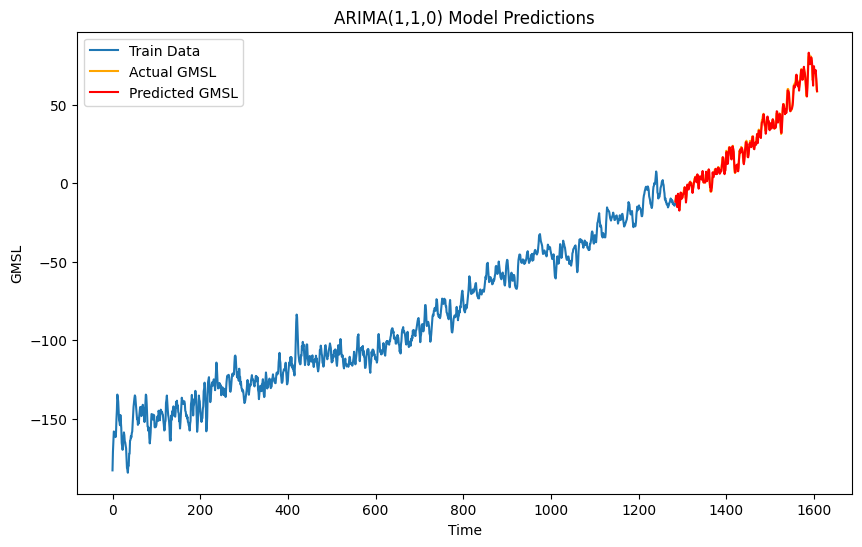

In [ ]:
# @title predict with model ARIMA (3,1,3)

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model = sm.tsa.ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['GMSL'], label='Train Data')
plt.plot(test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')
plt.title('ARIMA(1,1,0) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()

Root Mean Squared Error (RMSE): 1.8529289291428055


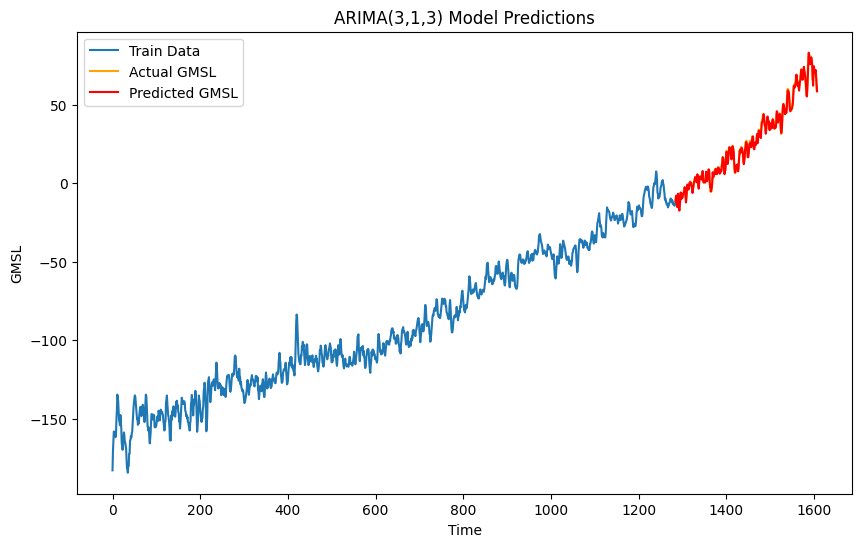

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Make rolling predictions
predictions = []
history = list(train_data['GMSL'])  # Simpan data training sebagai basis prediksi

for t in range(len(test_data)):
    model = sm.tsa.ARIMA(history, order=(3,1,3))  # Model ARIMA(3,1,3)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]  # Prediksi satu langkah ke depan
    predictions.append(yhat)
    history.append(test_data['GMSL'].iloc[t])  # Update history dengan nilai aktual

# Evaluate the model
mse = mean_squared_error(test_data['GMSL'], predictions)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['GMSL'], label='Train Data')
plt.plot(test_data.index, test_data['GMSL'], label='Actual GMSL', color='orange')
plt.plot(test_data.index, predictions, label='Predicted GMSL', color='red')  # Use index for x-axis
plt.title('ARIMA(3,1,3) Model Predictions')
plt.xlabel('Time')
plt.ylabel('GMSL')
plt.legend()
plt.show()
